In [ ]:
import pandas as pd
import os
import pyarrow.parquet as pq
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, matthews_corrcoef, fbeta_score, average_precision_score
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data

In [2]:
df = pd.read_parquet('../Dataset/train.parquet')

In [3]:
X = df.drop(['is_anomaly', 'id'], axis=1)
y = df['is_anomaly']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
n_anomalies = y.sum()

print(f"Number of elements: {len(X)}")
print(f"Number of anomalies: {n_anomalies}")
print(f"Anomalies percentage: {len(X) / n_anomalies}")

Number of elements: 14728321
Number of anomalies: 1544104
Anomalies percentage: 9.538425520560791


# Model

In [ ]:
model_path = r"..\Models\xgboost_model.json"

if os.path.exists(model_path):
    model = xgb.XGBClassifier()
    model.load_model(model_path)
    print("✅ Modello XGBoost caricato correttamente.")
else:
    print("❌ File del modello non trovato.")

    scale = (len(y_train) - sum(y_train)) / sum(y_train)


    model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale
    )
    model.fit(X_train, y_train)

    model.save_model(model_path)


y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]


print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=3))

print("ROC AUC Score:", roc_auc_score(y_val, y_proba))

print("Balanced Accuracy:", balanced_accuracy_score(y_val, y_pred))

print("Matthews Correlation Coefficient:", matthews_corrcoef(y_val, y_pred)) #unbalanced dataset

print("F2 Score:", fbeta_score(y_val, y_pred, beta=2)) #minimize false negatives (anomalies)

print("PR AUC (Average Precision):", average_precision_score(y_val, y_proba))

print("Brier Score:", brier_score_loss(y_val, y_proba)) #accuracy of probabilities

✅ Modello XGBoost caricato correttamente.
Confusion Matrix:
[[2618436   18408]
 [   2550  306271]]

Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.993     0.996   2636844
           1      0.943     0.992     0.967    308821

    accuracy                          0.993   2945665
   macro avg      0.971     0.992     0.981   2945665
weighted avg      0.993     0.993     0.993   2945665

ROC AUC Score: 0.9995415334106545
Balanced Accuracy: 0.9923808583421998
Matthews Correlation Coefficient: 0.9633128139090262
F2 Score: 0.9816611035005317
PR AUC (Average Precision): 0.9974301381814988
Brier Score: 0.006327822715457097


In [4]:
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

11782656
2945665
11782656
2945665


## Most important features

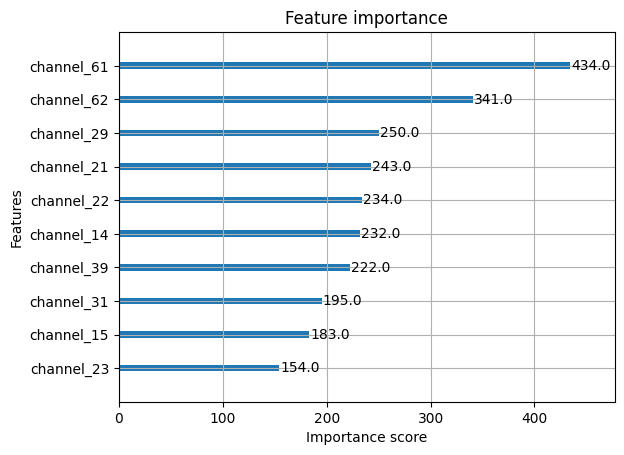

In [ ]:
xgb.plot_importance(model, max_num_features=10)
plt.show()

In [14]:
correlations = df.corr(numeric_only=True)['is_anomaly'].sort_values(ascending=False)
print(correlations.head(10))

is_anomaly    1.000000
channel_47    0.088230
channel_48    0.088221
channel_49    0.088215
channel_3     0.085011
channel_2     0.084728
channel_1     0.073403
channel_21    0.066923
channel_28    0.064934
channel_14    0.061508
Name: is_anomaly, dtype: float64


# PCA

## Full dataset

### 2D

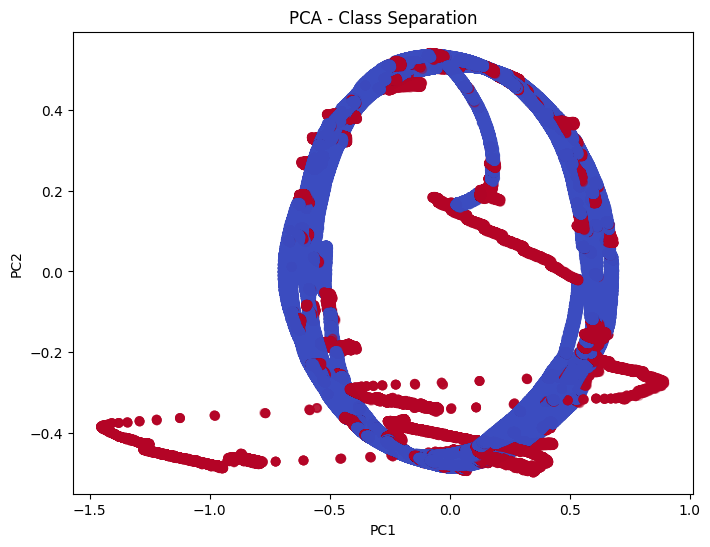

In [5]:
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_proj[:,0], X_proj[:,1], c=y, cmap='coolwarm', alpha=0.3)
plt.title("PCA - Class Separation")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### 3D

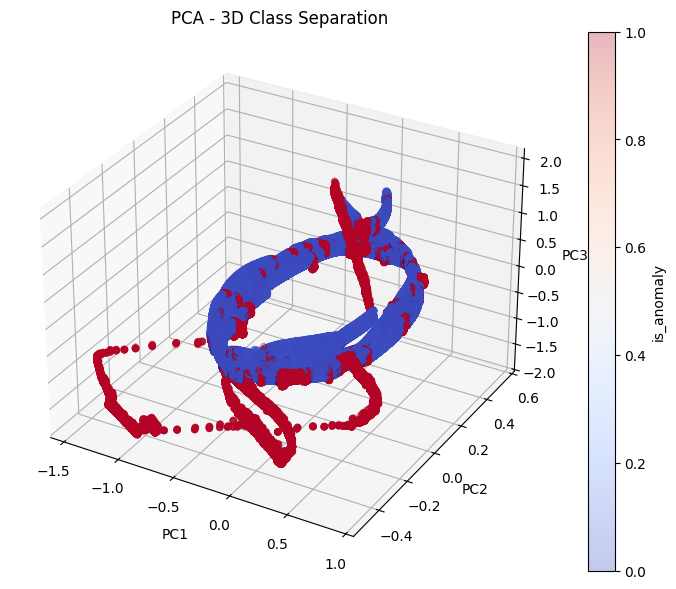

In [ ]:
# PCA con 3 componenti
pca = PCA(n_components=3)
X_proj = pca.fit_transform(X)

# Plot 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], c=y, cmap='coolwarm', alpha=0.3)

ax.set_title("PCA - 3D Class Separation")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(sc, label='is_anomaly')
plt.show()


## Evaluation Dataset 3D

### Ground truth labels

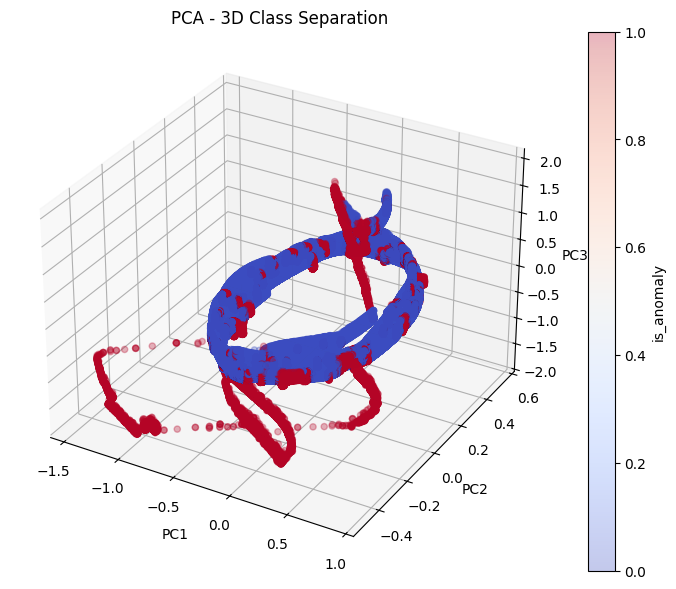

In [ ]:
pca = PCA(n_components=3)
X_proj = pca.fit_transform(X_val)

# Plot 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], c=y_val, cmap='coolwarm', alpha=0.3)

ax.set_title("PCA - 3D Class Separation")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(sc, label='is_anomaly')
plt.show()

### Predicted labels

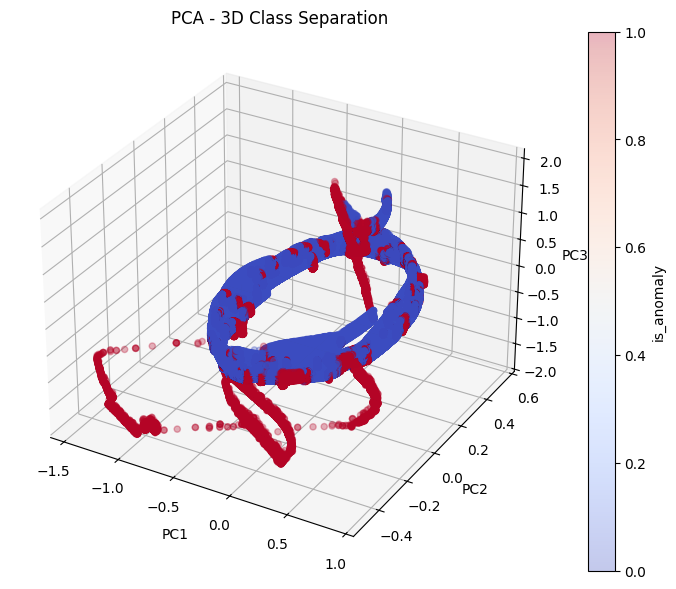

In [ ]:
pca = PCA(n_components=3)
X_proj = pca.fit_transform(X_val)

# Plot 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], c=y_pred, cmap='coolwarm', alpha=0.3)

ax.set_title("PCA - 3D Class Separation")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(sc, label='is_anomaly')
plt.show()